![Colegio Bourbaki](./Images/Bourbaki.png)

## Machine Learning & AI

### Introducción a modelos autorregresivos

### Contexto

SNCF-Transilien es el operador de la red de cercanías de SNCF que cubre la región parisina. Circula más de 6.200 trenes al día y desplaza a 3,4 millones de pasajeros. SNCF-Transilien recopila cada vez más datos sobre el número de pasajeros a bordo mediante sensores de infrarrojos en las puertas. Esta creciente cantidad de datos permite a SNCF-Transilien ofrecer nuevos servicios a los pasajeros y mejorar su rendimiento operativo.

El objetivo de este reto es dotar a SNCF-Transilien de las herramientas necesarias para ofrecer una previsión precisa de la tasa de ocupación de los trenes. De este modo, ofrecer a sus viajeros información precisa sobre la aglomeración en tiempo real (RTCI) a través de servicios digitales.

Cuando un viajero está esperando un tren k en la estación s, el tren puede estar varias estaciones más adelante, pero queremos dar a los viajeros la información más coherente posible sobre lo ocupado que estará el tren cuando suban a él. Para ello, necesitamos predecir para cada tren los índices de ocupación reales en las estaciones siguientes. En este caso, proponemos predecir, de forma más sencilla, el grado de ocupación sólo en la siguiente estación.

### Datos

La variable k se utiliza para especificar el tren, s para la estación y d para el día. Una parada viene dada por la tripleta k, s, d.

Tenemos 4 archivos:

* Un conjunto de datos Xtrain.csv con 31 119 filas (es decir, 31 119 paradas k, s, d) y 12 columnas
* Un conjunto de datos Xtest.csv con 13 752 filas (es decir, 13 752 paradas k, s, d) y 12 columnas.
* Un conjunto de datos Ytrain.csv con 31 119 filas y una columna, que proporciona la variable objetivo que debe predecirse para el conjunto de entrenamiento.
* Un conjunto de datos Ysample.csv con 13 752 filas y una columna con valores aleatorios entre [0, 1], que es un ejemplo de envío que puede utilizar para preparar su propio envío

Origen de los datos

Los datos proceden de sensores de infrarrojos situados encima de cada puerta del material rodante (NAT, R2N) en Île-de-France, que miden el número de pasajeros que suben y bajan por puerta. Estos datos se captan en tiempo real y sólo son accesibles a escala del tren para este reto. El factor de ocupación es el número de pasajeros a bordo dividido por la capacidad total del tren.

Queremos predecir el índice de ocupación en tiempo real utilizando el pasado cercano.

Introducimos las notaciones p y q para describir el pasado: 

* p se utiliza para los valores pasados de los trenes anteriores en la misma estación 
* q se utiliza para describir las paradas anteriores del mismo tren.

La tasa de ocupación real es: p0q0 ∈ [0,1] que es el factor de aglomeración/tasa de ocupación, anotado Y(k,s,d), para una parada que es un tren k en una estación s durante un día d.

Las columnas, es decir, las características, se dividen en 6 variables contextuales, como el día, la identificación del tren, etc., y 6 variables de retardo:

Variables contextuales

* Fecha $d$: AAAAMMDD es la fecha del id de tren recorrido

* Tren $k$: 1, 2, ..., 55 id tren (único por día d)

* Estación $s$: AA, AB, AC,... es el identificador de la estación

* Hora: $HH:00:00$ es la franja horaria

* Vía: $0, 1$ es la vía del tren con 0 (hacia París) o 1 (hacia las afueras)

* Composición: $1, 2$ es el número de unidades de tren (una o dos)


Variables de desfase

* $p1q0$ ∈ [0,1] es el índice de ocupación del tren k-1 anterior en la misma estación s

* $p2q0$ ∈ [0,1] es el índice de ocupación del segundo tren anterior k-2 en la misma estación s

* $p3q0$ ∈ [0,1] es el índice de ocupación del tercer tren anterior k-3 en la misma estación s

* $p0q1$ ∈ [0,1] es el índice de ocupación del mismo tren k en la estación anterior s-1

* $p0q2$ ∈ [0,1] es el índice de ocupación del mismo tren k en la segunda estación anterior s-2

* $p0q3$ ∈ [0,1] es el índice de ocupación del mismo tren k en la tercera estación anterior s-3

Las variables de desfase son NA si el desfase no existe para la parada debido a la estructura del horario. Todos los demás valores perdidos se han imputado mediante un algoritmo comercial.

Para más detalles sobre el conjunto de datos o sobre el modelo de referencia, véase nuestro artículo One-Station-Ahead Forecasting of Dwell Time, Arrival Delay and Passenger Flows on Trains Equipped with Automatic Passenger Counting (APC) Device.

Link: https://challengedata.ens.fr/participants/challenges/89/

### Librerías

In [68]:
#Data Analysis
import numpy as np
import pandas as pd

#Plotting
import matplotlib.pyplot as plt

#LSTM
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

#Utils
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

### Configuración

In [69]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [70]:
device

device(type='cuda')

### Carga de Datos

In [71]:
df_x_train = pd.read_csv('./Data/Xtrain_hgcGIrA.csv')

In [73]:
df_x_train

,date,train,way,station,hour,composition,p1q0,p2q0,p3q0,p0q1,p0q2,p0q3
0,2019-01-07,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.201,0.138,0.091
1,2019-01-08,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.204,0.152,0.106
2,2019-01-10,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.213,0.153,0.111
3,2019-01-11,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.213,0.152,0.108
4,2019-01-14,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.210,0.147,0.096
...,...,...,...,...,...,...,...,...,...,...,...,...
31114,2019-05-13,9,0,BE,08:00:00,2,0.152,0.18860,0.157000,0.080,0.100,NaN
31115,2019-05-14,9,0,BE,08:00:00,2,0.153,0.18040,0.191000,0.089,0.121,NaN
31116,2019-05-15,9,0,BE,08:00:00,2,0.166,0.14900,0.168000,0.099,0.129,NaN
31117,2019-03-21,9,0,BE,08:00:00,2,0.182,0.19300,0.162000,0.074,0.101,NaN


In [74]:
df_x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31119 entries, 0 to 31118
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         31119 non-null  object 
 1   train        31119 non-null  int64  
 2   way          31119 non-null  int64  
 3   station      31119 non-null  object 
 4   hour         27915 non-null  object 
 5   composition  31119 non-null  int64  
 6   p1q0         29067 non-null  float64
 7   p2q0         26974 non-null  float64
 8   p3q0         24935 non-null  float64
 9   p0q1         27917 non-null  float64
 10  p0q2         24720 non-null  float64
 11  p0q3         21527 non-null  float64
dtypes: float64(6), int64(3), object(3)
memory usage: 2.8+ MB


In [75]:
df_x_train['hour'].value_counts(dropna=False)

hour
07:00:00    10064
08:00:00    10028
06:00:00     4995
NaN          3204
09:00:00     2826
11:00:00        2
Name: count, dtype: int64

Casteamos la variable date a datetime:

In [76]:
df_x_train['date'] = pd.to_datetime(df_x_train['date'])

Veamos las diferentes estaciones:

In [77]:
df_x_train['station'].unique() 

array(['AD', 'AI', 'AJ', 'AK', 'AM', 'AT', 'AW', 'AX', 'BB', 'BD', 'BE',
       'AE', 'AL', 'AO', 'AQ', 'BC', 'AB', 'AN', 'AS', 'BF', 'BG', 'BH',
       'AV', 'AF', 'AP', 'AZ', 'AA', 'AC', 'AG', 'AH', 'AR', 'AU', 'BA',
       'BI', 'BJ', 'AY'], dtype=object)

In [78]:
print(f"Hay {np.count_nonzero(df_x_train['station'].unique())} estaciones")

Hay 36 estaciones


Veamos cuántos trenes hay disponibles:

In [79]:
df_x_train['train'].unique()

array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54, 55,
        6,  7,  8,  9])

In [80]:
print(f"Hay {np.count_nonzero(df_x_train['train'].unique())} trenes")

Hay 55 trenes


Reorganizamos el dataset:

In [81]:
df_train = df_x_train.copy(deep=True)

In [82]:
# Handle NaN values by replacing them with 0
df_train.fillna(0, inplace=True)

In [83]:
df_train['hour'].value_counts()

hour
07:00:00    10064
08:00:00    10028
06:00:00     4995
0            3204
09:00:00     2826
11:00:00        2
Name: count, dtype: int64

In [84]:
# Combine the 'date' and 'hour' columns into a single datetime column
df_train['hour'] = df_train['hour'].apply(lambda x: '10:00:00' if x == 0 else x)
df_train['datetime'] = pd.to_datetime(df_train['date'].dt.date.astype(str) + ' ' + df_train['hour'].astype(str))

Observemos el formato de sumisión al reto:

In [85]:
ysample = pd.read_csv('./Data/Ysample_iX1anNa.csv')

In [86]:
ysample

,Unnamed: 0,p0q0
0,1,0.288
1,2,0.788
2,3,0.409
3,4,0.883
4,5,0.940
...,...,...
13747,13748,0.373
13748,13749,0.732
13749,13750,0.273
13750,13751,0.728


Vamos a leer las 'etiquetas':

In [87]:
y_train= pd.read_csv('./Data/Ytrain_yL5OjS4.csv')

In [88]:
df = y_train[['p0q0']]

In [90]:
df

,p0q0
0,0.216
1,0.216
2,0.227
3,0.229
4,0.225
...,...
31114,0.111
31115,0.143
31116,0.139
31117,0.117


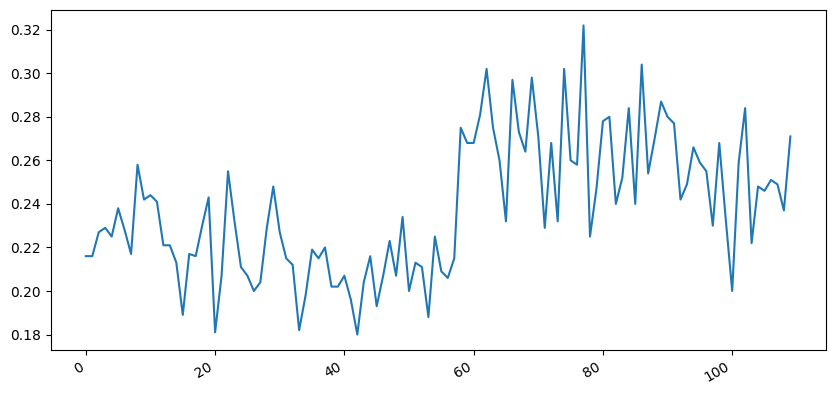

In [93]:
fig = plt.figure(figsize=(10, 5))
plt.plot(df.iloc[:110])
plt.gcf().autofmt_xdate()
plt.show()

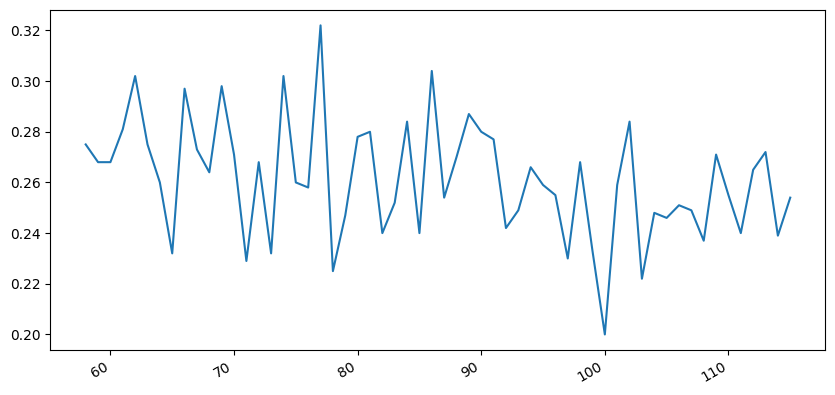

In [94]:
fig = plt.figure(figsize=(10, 5))
plt.plot(df.iloc[58:2*58])
plt.gcf().autofmt_xdate()
plt.show()

Vamos a pronosticar para un solo tren:

In [95]:
datos = pd.concat([df,df_train], axis=1)
datos = datos[['p0q0','p1q0','p2q0','p3q0','p0q1','p0q2','p0q3','train','composition','way','station','datetime','date','hour']]

In [96]:
datos.head()

,p0q0,p1q0,p2q0,p3q0,p0q1,p0q2,p0q3,train,composition,way,station,datetime,date,hour
0,0.216,0.0,0.0,0.0,0.201,0.138,0.091,1,2,0,AD,2019-01-07 06:00:00,2019-01-07,06:00:00
1,0.216,0.0,0.0,0.0,0.204,0.152,0.106,1,2,0,AD,2019-01-08 06:00:00,2019-01-08,06:00:00
2,0.227,0.0,0.0,0.0,0.213,0.153,0.111,1,2,0,AD,2019-01-10 06:00:00,2019-01-10,06:00:00
3,0.229,0.0,0.0,0.0,0.213,0.152,0.108,1,2,0,AD,2019-01-11 06:00:00,2019-01-11,06:00:00
4,0.225,0.0,0.0,0.0,0.210,0.147,0.096,1,2,0,AD,2019-01-14 06:00:00,2019-01-14,06:00:00


In [97]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31119 entries, 0 to 31118
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   p0q0         31119 non-null  float64       
 1   p1q0         31119 non-null  float64       
 2   p2q0         31119 non-null  float64       
 3   p3q0         31119 non-null  float64       
 4   p0q1         31119 non-null  float64       
 5   p0q2         31119 non-null  float64       
 6   p0q3         31119 non-null  float64       
 7   train        31119 non-null  int64         
 8   composition  31119 non-null  int64         
 9   way          31119 non-null  int64         
 10  station      31119 non-null  object        
 11  datetime     31119 non-null  datetime64[ns]
 12  date         31119 non-null  datetime64[ns]
 13  hour         31119 non-null  object        
dtypes: datetime64[ns](2), float64(7), int64(3), object(2)
memory usage: 3.3+ MB


In [98]:
datos.set_index('datetime', inplace=True)

In [99]:
datos.drop(['date','hour'], axis=1, inplace=True)

In [100]:
datos

,p0q0,p1q0,p2q0,p3q0,p0q1,p0q2,p0q3,train,composition,way,station
datetime,,,,,,,,,,,
2019-01-07 06:00:00,0.216,0.000,0.00000,0.000000,0.201,0.138,0.091,1,2,0,AD
2019-01-08 06:00:00,0.216,0.000,0.00000,0.000000,0.204,0.152,0.106,1,2,0,AD
2019-01-10 06:00:00,0.227,0.000,0.00000,0.000000,0.213,0.153,0.111,1,2,0,AD
2019-01-11 06:00:00,0.229,0.000,0.00000,0.000000,0.213,0.152,0.108,1,2,0,AD
2019-01-14 06:00:00,0.225,0.000,0.00000,0.000000,0.210,0.147,0.096,1,2,0,AD
...,...,...,...,...,...,...,...,...,...,...,...
2019-05-13 08:00:00,0.111,0.152,0.18860,0.157000,0.080,0.100,0.000,9,2,0,BE
2019-05-14 08:00:00,0.143,0.153,0.18040,0.191000,0.089,0.121,0.000,9,2,0,BE
2019-05-15 08:00:00,0.139,0.166,0.14900,0.168000,0.099,0.129,0.000,9,2,0,BE


In [101]:
train = 1
station = 'AD'
#Filter the DataFrame for train x ans station y
train_df = datos[(datos['train'] == train) & (datos['station'] == station)]

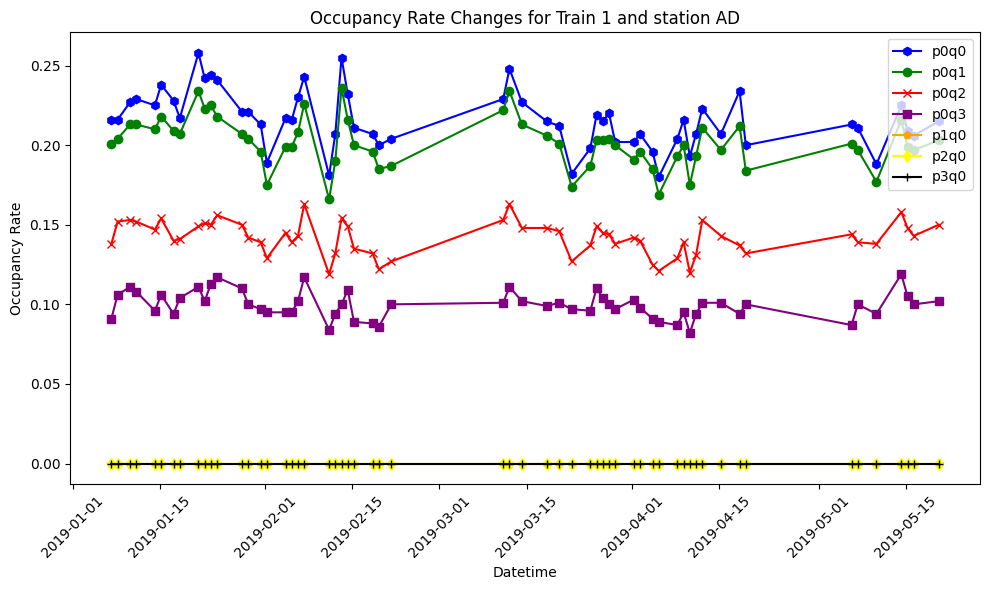

In [102]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_df.index, train_df['p0q0'], label='p0q0', marker='h', color='blue')
plt.plot(train_df.index, train_df['p0q1'], label='p0q1', marker='o', color='green')
plt.plot(train_df.index, train_df['p0q2'], label='p0q2', marker='x', color='red')
plt.plot(train_df.index, train_df['p0q3'], label='p0q3', marker='s', color='purple')
plt.plot(train_df.index, train_df['p1q0'], label='p1q0', marker='p', color='orange')
plt.plot(train_df.index, train_df['p2q0'], label='p2q0', marker='d', color='yellow')
plt.plot(train_df.index, train_df['p3q0'], label='p3q0', marker='+', color='black')

# Formatting the plot
plt.title(f'Occupancy Rate Changes for Train {train} and station {station}')
plt.xlabel('Datetime')
plt.ylabel('Occupancy Rate')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [103]:
train = 2
station = 'AI'
train_df = datos[(datos['train'] == train) & (datos['station'] == station)]

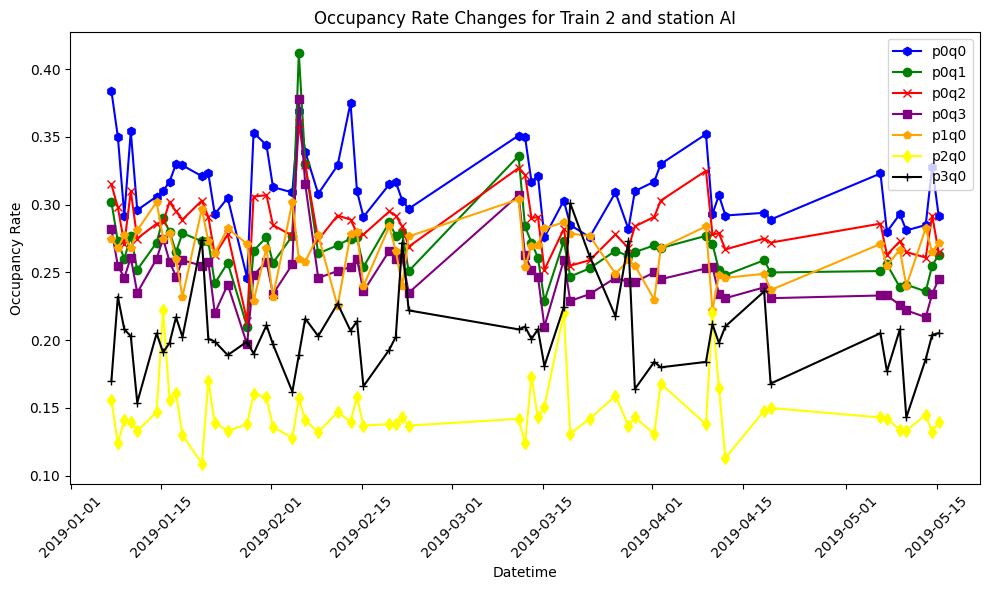

In [104]:
plt.figure(figsize=(10, 6))
plt.plot(train_df.index, train_df['p0q0'], label='p0q0', marker='h', color='blue')
plt.plot(train_df.index, train_df['p0q1'], label='p0q1', marker='o', color='green')
plt.plot(train_df.index, train_df['p0q2'], label='p0q2', marker='x', color='red')
plt.plot(train_df.index, train_df['p0q3'], label='p0q3', marker='s', color='purple')
plt.plot(train_df.index, train_df['p1q0'], label='p1q0', marker='p', color='orange')
plt.plot(train_df.index, train_df['p2q0'], label='p2q0', marker='d', color='yellow')
plt.plot(train_df.index, train_df['p3q0'], label='p3q0', marker='+', color='black')
plt.title(f'Occupancy Rate Changes for Train {train} and station {station}')
plt.xlabel('Datetime')
plt.ylabel('Occupancy Rate')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Vamos a quedarnos con el tren número 1:

In [105]:
train_order = {train: index for index, train in enumerate(datos['train'].unique(), start=1)}

In [106]:
train_order

{1: 1,
 10: 2,
 11: 3,
 12: 4,
 13: 5,
 14: 6,
 15: 7,
 16: 8,
 17: 9,
 18: 10,
 19: 11,
 2: 12,
 20: 13,
 21: 14,
 22: 15,
 23: 16,
 24: 17,
 25: 18,
 26: 19,
 27: 20,
 28: 21,
 29: 22,
 3: 23,
 30: 24,
 31: 25,
 32: 26,
 33: 27,
 34: 28,
 35: 29,
 36: 30,
 37: 31,
 38: 32,
 39: 33,
 4: 34,
 40: 35,
 41: 36,
 42: 37,
 43: 38,
 44: 39,
 45: 40,
 46: 41,
 47: 42,
 48: 43,
 49: 44,
 5: 45,
 50: 46,
 51: 47,
 52: 48,
 53: 49,
 54: 50,
 55: 51,
 6: 52,
 7: 53,
 8: 54,
 9: 55}

In [107]:
rest = datos[datos['train'] == 1]

In [108]:
rest['station'].value_counts(dropna=False)

station
AD    58
AI    58
AJ    58
AK    58
AM    58
AT    58
AW    58
AX    58
BB    58
BD    58
BE    58
Name: count, dtype: int64

Realizamos un one-hot encoding sobre las estaciones:

In [109]:
rest = pd.get_dummies(rest, prefix='station')

In [110]:
rest.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 638 entries, 2019-01-07 06:00:00 to 2019-05-20 06:00:00
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   p0q0         638 non-null    float64
 1   p1q0         638 non-null    float64
 2   p2q0         638 non-null    float64
 3   p3q0         638 non-null    float64
 4   p0q1         638 non-null    float64
 5   p0q2         638 non-null    float64
 6   p0q3         638 non-null    float64
 7   train        638 non-null    int64  
 8   composition  638 non-null    int64  
 9   way          638 non-null    int64  
 10  station_AD   638 non-null    bool   
 11  station_AI   638 non-null    bool   
 12  station_AJ   638 non-null    bool   
 13  station_AK   638 non-null    bool   
 14  station_AM   638 non-null    bool   
 15  station_AT   638 non-null    bool   
 16  station_AW   638 non-null    bool   
 17  station_AX   638 non-null    bool   
 18  station_BB   

In [111]:
X = rest.iloc[:,1:]
y = rest.iloc[:,0]

In [112]:
X.drop('train', axis=1, inplace=True)

In [113]:
X

,p1q0,p2q0,p3q0,p0q1,p0q2,p0q3,composition,way,station_AD,station_AI,station_AJ,station_AK,station_AM,station_AT,station_AW,station_AX,station_BB,station_BD,station_BE
datetime,,,,,,,,,,,,,,,,,,,
2019-01-07 06:00:00,0.0,0.0,0.0,0.201,0.138,0.091,2,0,True,False,False,False,False,False,False,False,False,False,False
2019-01-08 06:00:00,0.0,0.0,0.0,0.204,0.152,0.106,2,0,True,False,False,False,False,False,False,False,False,False,False
2019-01-10 06:00:00,0.0,0.0,0.0,0.213,0.153,0.111,2,0,True,False,False,False,False,False,False,False,False,False,False
2019-01-11 06:00:00,0.0,0.0,0.0,0.213,0.152,0.108,2,0,True,False,False,False,False,False,False,False,False,False,False
2019-01-14 06:00:00,0.0,0.0,0.0,0.210,0.147,0.096,2,0,True,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-10 06:00:00,0.0,0.0,0.0,0.047,0.066,0.000,2,0,False,False,False,False,False,False,False,False,False,False,True
2019-05-14 06:00:00,0.0,0.0,0.0,0.052,0.080,0.000,2,0,False,False,False,False,False,False,False,False,False,False,True
2019-05-15 06:00:00,0.0,0.0,0.0,0.049,0.070,0.000,2,0,False,False,False,False,False,False,False,False,False,False,True


In [114]:
y

datetime
2019-01-07 06:00:00    0.216
2019-01-08 06:00:00    0.216
2019-01-10 06:00:00    0.227
2019-01-11 06:00:00    0.229
2019-01-14 06:00:00    0.225
                       ...  
2019-05-10 06:00:00    0.088
2019-05-14 06:00:00    0.102
2019-05-15 06:00:00    0.091
2019-05-16 06:00:00    0.089
2019-05-20 06:00:00    0.089
Name: p0q0, Length: 638, dtype: float64

Vamos a separar en conjunto de entrenamiento y prueba:

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, shuffle=False)

### Training

In [116]:
X_train

,p1q0,p2q0,p3q0,p0q1,p0q2,p0q3,composition,way,station_AD,station_AI,station_AJ,station_AK,station_AM,station_AT,station_AW,station_AX,station_BB,station_BD,station_BE
datetime,,,,,,,,,,,,,,,,,,,
2019-01-07 06:00:00,0.0000,0.00000,0.0,0.201,0.138,0.091,2,0,True,False,False,False,False,False,False,False,False,False,False
2019-01-08 06:00:00,0.0000,0.00000,0.0,0.204,0.152,0.106,2,0,True,False,False,False,False,False,False,False,False,False,False
2019-01-10 06:00:00,0.0000,0.00000,0.0,0.213,0.153,0.111,2,0,True,False,False,False,False,False,False,False,False,False,False
2019-01-11 06:00:00,0.0000,0.00000,0.0,0.213,0.152,0.108,2,0,True,False,False,False,False,False,False,False,False,False,False
2019-01-14 06:00:00,0.0000,0.00000,0.0,0.210,0.147,0.096,2,0,True,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-04 06:00:00,0.2080,0.18800,0.0,0.233,0.245,0.217,2,0,False,False,False,False,False,False,False,False,True,False,False
2019-04-05 06:00:00,0.2140,0.17572,0.0,0.200,0.227,0.182,2,0,False,False,False,False,False,False,False,False,True,False,False
2019-04-08 06:00:00,0.1520,0.28500,0.0,0.259,0.278,0.232,2,0,False,False,False,False,False,False,False,False,True,False,False


In [117]:
y_train.head()

datetime
2019-01-07 06:00:00    0.216
2019-01-08 06:00:00    0.216
2019-01-10 06:00:00    0.227
2019-01-11 06:00:00    0.229
2019-01-14 06:00:00    0.225
Name: p0q0, dtype: float64

In [118]:
X_train.iloc[:, :8]

,p1q0,p2q0,p3q0,p0q1,p0q2,p0q3,composition,way
datetime,,,,,,,,
2019-01-07 06:00:00,0.0000,0.00000,0.0,0.201,0.138,0.091,2,0
2019-01-08 06:00:00,0.0000,0.00000,0.0,0.204,0.152,0.106,2,0
2019-01-10 06:00:00,0.0000,0.00000,0.0,0.213,0.153,0.111,2,0
2019-01-11 06:00:00,0.0000,0.00000,0.0,0.213,0.152,0.108,2,0
2019-01-14 06:00:00,0.0000,0.00000,0.0,0.210,0.147,0.096,2,0
...,...,...,...,...,...,...,...,...
2019-04-04 06:00:00,0.2080,0.18800,0.0,0.233,0.245,0.217,2,0
2019-04-05 06:00:00,0.2140,0.17572,0.0,0.200,0.227,0.182,2,0
2019-04-08 06:00:00,0.1520,0.28500,0.0,0.259,0.278,0.232,2,0


In [119]:
X_train_tensor = torch.tensor(X_train.iloc[:, :8].to_numpy())
y_train_tensor = torch.tensor(y_train.to_numpy())
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

In [122]:
train_dataset[0]

(tensor([0.0000, 0.0000, 0.0000, 0.2010, 0.1380, 0.0910, 2.0000, 0.0000],
        dtype=torch.float64),
 tensor(0.2160, dtype=torch.float64))

In [123]:
BATCH_SIZE = 1

Generamos el dataloader para el modelo:

In [124]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Modelo RNN/LSTM

**Redes Neuronales Recurrentes (RNN):**

Las RNN son un tipo de red neuronal artificial diseñadas para reconocer patrones en secuencias de datos como series temporales, lenguaje hablado, texto escrito o datos financieros. Para nuestro caso, una RNN podría usar datos históricos sobre la tasa de ocupación de los trenes para aprender a predecir futuras tasas de ocupación. Lo que hace especial a las RNN es su capacidad de memoria a corto plazo. Pueden recordar información previa en la secuencia y usarla para influir en la salida actual. Sin embargo, las RNN tradicionales luchan con dependencias a largo plazo debido a problemas como la desaparición o la explosión del gradiente.

![RNN](./Images/RNNIO.png)

Fuente: Chapter 6 - Python Deep Learning - Ivan Vasilev

**Long Short-Term Memory (LSTM):**

Las LSTM son una mejora de las RNN convencionales. Están específicamente diseñadas para evitar el problema de la dependencia a largo plazo, permitiendo que el modelo aprenda qué información es relevante para mantener o descartar a lo largo de grandes intervalos de tiempo. Esto se logra a través de estructuras llamadas celdas de memoria que tienen puertas para regular el flujo de información. Estas puertas pueden aprender cuáles datos son importantes y por lo tanto deben ser recordados y cuáles pueden ser olvidados. En el contexto de la tasa de ocupación de los trenes, una LSTM podría potencialmente capturar complejas relaciones temporales, como los patrones de afluencia de pasajeros en diferentes estaciones durante diferentes horarios y días, mejorando la precisión de las predicciones.

![RNN](./Images/LSTMarch.png)

![RNN](./Images/LSTMflow.png)

Fuente: Chapter 6 - Python Deep Learning - Ivan Vasilev

En resumen, las RNN y las LSTM son adecuadas para modelar problemas donde los datos vienen en secuencias y la información histórica es crucial para hacer predicciones. Para la predicción de la tasa de ocupación de los trenes, una LSTM probablemente superará a una RNN estándar, ya que puede manejar mejor las dependencias temporales a largo plazo que son comunes en los datos de tráfico de pasajeros.

Vamos a definir la arquitectura de la red recurrente:

In [125]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, batch_first=True):
        super(LSTMModel, self).__init__()
        # Define hyperparameters
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.output_size = output_size
        
        # Define LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=batch_first, dropout=0.2, bidirectional=False)
        
        # Define fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        #Initializations
        self.lstm.flatten_parameters()
        h0 = torch.zeros(self.num_layers, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, self.hidden_size).to(device)

        # Forward pass
        output, (h_n, c_n) = self.lstm(x, (h0, c0))
        
        # if self.batch_first:
        #     out = output[:, -1]  # For batch_first=True
        # else:
        #     out = output[-1, :]  # For batch_first=False
        
        # Forward pass through the fully connected layer
        out = self.fc(output)
        return out

In [126]:
# Define the parameters
input_size = train_dataset[0][0].shape[0]
HIDDEN_SIZE = 64
LAYERS = 2
OUTPUT = 1
LR = 0.0001
EPOCHS = 30  

In [127]:
# Initialize the model
model = LSTMModel(input_size, HIDDEN_SIZE, LAYERS, OUTPUT)
model.to(device)

LSTMModel(
  (lstm): LSTM(8, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [128]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR, amsgrad=True, weight_decay=LR*0.1)
criterion = nn.MSELoss()

In [129]:
def train_model(model, optimizer, criterion, train_loader, num_epochs):
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad(set_to_none=True)  # Zero the gradients
            
            # Forward pass
            inputs = inputs.to(device)
            outputs = model(inputs.float())
            loss = criterion(outputs.float().squeeze(), labels.float().squeeze().to(device))
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.5f}')
    print('Finished Training')

In [130]:
train_model(model, optimizer, criterion, train_loader, EPOCHS)

Epoch [1/30], Loss: 0.03005
Epoch [2/30], Loss: 0.00341
Epoch [3/30], Loss: 0.00297
Epoch [4/30], Loss: 0.00273
Epoch [5/30], Loss: 0.00252
Epoch [6/30], Loss: 0.00217
Epoch [7/30], Loss: 0.00205
Epoch [8/30], Loss: 0.00179
Epoch [9/30], Loss: 0.00160
Epoch [10/30], Loss: 0.00150
Epoch [11/30], Loss: 0.00140
Epoch [12/30], Loss: 0.00132
Epoch [13/30], Loss: 0.00134
Epoch [14/30], Loss: 0.00139
Epoch [15/30], Loss: 0.00120
Epoch [16/30], Loss: 0.00126
Epoch [17/30], Loss: 0.00131
Epoch [18/30], Loss: 0.00119
Epoch [19/30], Loss: 0.00127
Epoch [20/30], Loss: 0.00128
Epoch [21/30], Loss: 0.00119
Epoch [22/30], Loss: 0.00114
Epoch [23/30], Loss: 0.00114
Epoch [24/30], Loss: 0.00115
Epoch [25/30], Loss: 0.00112
Epoch [26/30], Loss: 0.00110
Epoch [27/30], Loss: 0.00103
Epoch [28/30], Loss: 0.00104
Epoch [29/30], Loss: 0.00102
Epoch [30/30], Loss: 0.00107
Finished Training


### Testing

In [131]:
X_test

,p1q0,p2q0,p3q0,p0q1,p0q2,p0q3,composition,way,station_AD,station_AI,station_AJ,station_AK,station_AM,station_AT,station_AW,station_AX,station_BB,station_BD,station_BE
datetime,,,,,,,,,,,,,,,,,,,
2019-04-11 06:00:00,0.204,0.19100,0.0,0.248,0.245,0.223,2,0,False,False,False,False,False,False,False,False,True,False,False
2019-04-12 06:00:00,0.203,0.16100,0.0,0.246,0.248,0.239,2,0,False,False,False,False,False,False,False,False,True,False,False
2019-04-15 06:00:00,0.196,0.17572,0.0,0.251,0.251,0.229,2,0,False,False,False,False,False,False,False,False,True,False,False
2019-04-18 06:00:00,0.183,0.19700,0.0,0.249,0.248,0.240,2,0,False,False,False,False,False,False,False,False,True,False,False
2019-04-19 06:00:00,0.163,0.13800,0.0,0.237,0.250,0.214,2,0,False,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-10 06:00:00,0.000,0.00000,0.0,0.047,0.066,0.000,2,0,False,False,False,False,False,False,False,False,False,False,True
2019-05-14 06:00:00,0.000,0.00000,0.0,0.052,0.080,0.000,2,0,False,False,False,False,False,False,False,False,False,False,True
2019-05-15 06:00:00,0.000,0.00000,0.0,0.049,0.070,0.000,2,0,False,False,False,False,False,False,False,False,False,False,True


In [132]:
y_test

datetime
2019-04-11 06:00:00    0.230
2019-04-12 06:00:00    0.236
2019-04-15 06:00:00    0.230
2019-04-18 06:00:00    0.228
2019-04-19 06:00:00    0.243
                       ...  
2019-05-10 06:00:00    0.088
2019-05-14 06:00:00    0.102
2019-05-15 06:00:00    0.091
2019-05-16 06:00:00    0.089
2019-05-20 06:00:00    0.089
Name: p0q0, Length: 128, dtype: float64

In [133]:
X_test_tensor = torch.tensor(X_test.iloc[:, :8].to_numpy())
y_test_tensor = torch.tensor(y_test.to_numpy())
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [134]:
# Set model to evaluation mode
model.eval()

# Initialize empty list to store predictions
all_predictions = []

# Iterate through the test dataset
for inputs, _ in test_loader:
    with torch.no_grad():
        outputs = model(inputs.float().to(device))
        # Convert predictions to numpy array and append to list
    all_predictions.append(outputs.cpu().numpy())

In [135]:
y_pred = np.concatenate(all_predictions, axis=0)

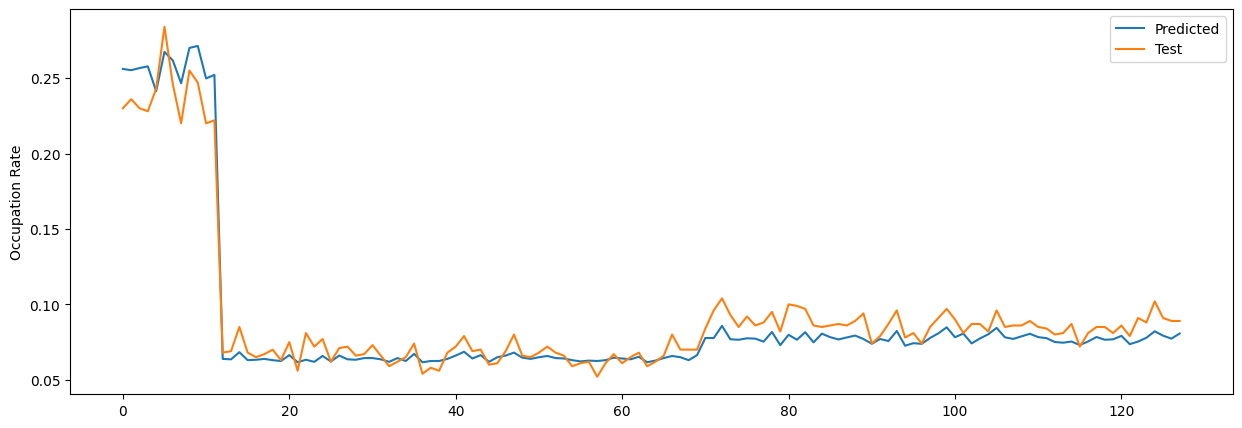

In [136]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(y_pred, label='Predicted')
ax.plot(y_test.to_list(), label='Test')
plt.legend(loc='upper right')
plt.ylabel('Occupation Rate')
plt.show()

In [137]:
print(f'El error cuadrático medio es: {mean_squared_error(y_test.to_list(), y_pred):.6f}')

El error cuadrático medio es: 0.000122


Veamos qué sucede con el conjunto de entrenamiento:

In [138]:
model.eval()
all_predictions = []
for inputs, _ in train_loader:
    with torch.no_grad():
        outputs = model(inputs.float().to(device))
    all_predictions.append(outputs.cpu().numpy())

y_pred = np.concatenate(all_predictions, axis=0)

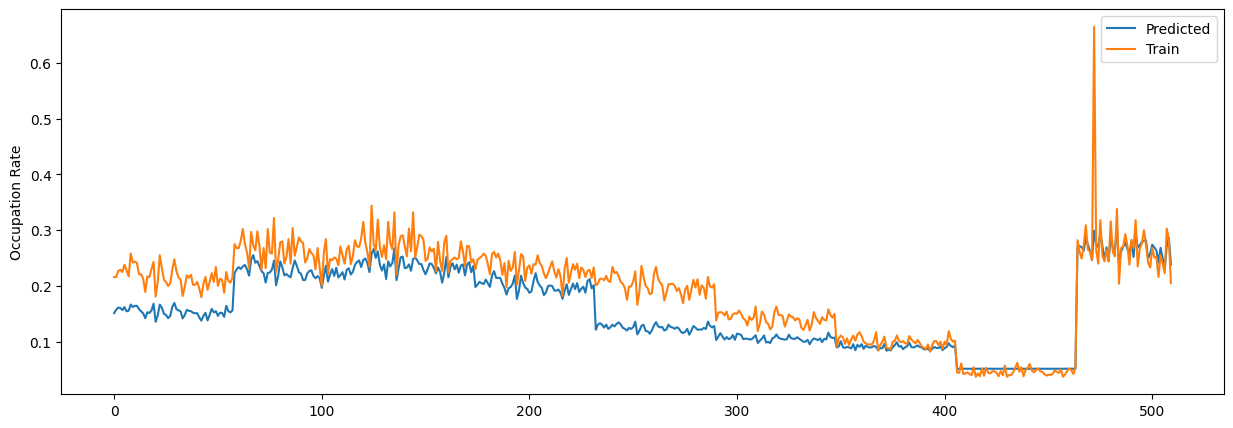

In [139]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(y_pred, label='Predicted')
ax.plot(y_train.to_list(), label='Train')
plt.legend(loc='upper right')
plt.ylabel('Occupation Rate')
plt.show()

In [140]:
print(f'El error cuadrático medio es: {mean_squared_error(y_train.to_list(), y_pred):.6f}')

El error cuadrático medio es: 0.002095


El valor es relativamente bajo, lo que puede sugerir que el modelo hace predicciones cercanas a los valores reales, al menos en el conjunto de datos utilizado para esta prueba. Sin embargo, la interpretación de este valor depende del contexto específico, como la escala de los datos de ocupación y la variabilidad inherente de las mediciones. En algunas aplicaciones, un MSE de este tamaño sería considerado muy bueno, mientras que en otras podría ser demasiado alto.

El gráfico obtenido sugiere que el modelo tiene cierta capacidad para seguir la tendencia de la ocupación real, pero hay margen de mejora. Es importante destacar que la utilidad de la predicción también depende de la rapidez con la que se pueda actualizar y comunicar a los pasajeros, ya que las condiciones en el sistema de transporte pueden cambiar rápidamente.

### Ejercicios:

* Predecir el factor de ocupación para otro tren del conjunto de entrenamiento y del archivo X_test

* Implementar una ventana o largo de la secuencia distinta para realizar la predicción del tren 1. Pueden utilizar: https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_sequence.html

* Ajustar mejor el modelo para este tren. Discutan cómo podrían implementar un sistema para actualizar los parámetros del modelo LSTM en tiempo real a medida que se disponga de nuevos datos de ocupación.

### Preguntas:

1) ¿Qué características de las RNN las hacen adecuadas para modelar secuencias temporales dedatos como las tasas de ocupación de trenes?

2) ¿Pueden explicar cómo las LSTM mejoran el desempeño de las RNN estándar y qué problemas específicos resuelven?

3) ¿Cómo se manejan las dependencias a largo plazo en los datos de series temporales utilizando LSTM?

4) ¿Cuáles son las diferencias clave entre una unidad LSTM y una neurona típica en una red neuronal?

5) ¿Cómo podrían utilizar la información de la tasa de ocupación de trenes anteriores para predecir la tasa de ocupación futura?

6) ¿Por qué es importante el proceso de "olvido" en una LSTM y cómo se implementa este mecanismo?

7) ¿Cómo se determina la cantidad de capas LSTM y la cantidad de unidades en cada capa para un problema de predicción de series temporales?

8) ¿Qué técnicas utilizarían para evitar el sobreajuste en un modelo LSTM que predice la ocupación de trenes?

9) ¿De qué manera la longitud de la secuencia de entrada afecta el rendimiento del modelo LSTM y cómo podrían decidir la longitud adecuada para su problema?

10) ¿Pueden describir cómo se realiza la retropropagación a través del tiempo (BPTT) en las LSTMs?

11) ¿Cómo interpretarían los resultados de la predicción mostrados en el gráfico compartido en términos de desempeño del modelo?

12) ¿Qué métricas de desempeño considerarían más importantes para evaluar la precisión de las predicciones de su modelo y por qué?



### Referencias:

* LSTM for Time Series Prediction in PyTorch: https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/

* How to apply LSTM using PyTorch: https://cnvrg.io/pytorch-lstm/

![Lenguaje Matemático](./Images/Matematicas.png)

![Contacto](./Images/Contacto.png)